<a href="https://colab.research.google.com/github/CIS6930-NLP/final_project/blob/main/Transformer_model_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### For practice: Empathetic Response Generation on EmpatheticDialogues

Paper for Empatheticdialogue Transformer model
https://arxiv.org/pdf/2204.11320v1.pdf
 

<figure>
<center>
<img src='https://drive.google.com/uc?id=1iXkrghQAzHF58ctIMWBMwpEk-L0EYlFi' />
<figcaption>Transformer Architecture</figcaption></center>
</figure>


#### Import libraries

In [1]:
import tensorflow as tf
import re
import nltk
import numpy as np
import math
import time
import pandas as pd
from google.colab import drive
from tensorflow.keras import layers
import tensorflow_datasets as tfds
# import keras_nlp
import matplotlib.pyplot as plt

print(tf.__version__)

2.11.0


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
#check GPU availability
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#### Data preprocessing

#### Load data

In [4]:
train_file = "/content/drive/MyDrive/code/Updated Data/train.csv"
val_file = "/content/drive/MyDrive/code/Updated Data/valid.csv"
test_file = "/content/drive/MyDrive/code/Updated Data/test.csv"
def data_loading(filepath): 
  data = pd.read_csv(filepath, encoding = 'utf-8')
  data = data.drop('conv_id', axis = 1)
  data = data.drop('utterance_idx', axis = 1)
  data = data.drop('speaker_idx', axis = 1)
  data = data.drop('selfeval', axis = 1)
  data = data.drop('tags', axis = 1)
  data = data.dropna()
  return data

train_data = data_loading(train_file)
val_data = data_loading(val_file)
test_data = data_loading(test_file)
train_data.head()

,Unnamed: 0,context,prompt,utterance
0,0,sentimental,I remember going to the fireworks with my best...,I remember going to see the fireworks with my ...
1,1,sentimental,I remember going to the fireworks with my best...,Was this a friend you were in love with_comma_...
2,2,sentimental,I remember going to the fireworks with my best...,This was a best friend. I miss her.
3,3,sentimental,I remember going to the fireworks with my best...,Where has she gone?
4,4,sentimental,I remember going to the fireworks with my best...,We no longer talk.


In [5]:
#Grouping emotions 
emotions = {}
emotions['excited'] = emotions['surprised'] = emotions['joyful'] = "excited"
emotions['afraid'] = emotions['terrified'] = emotions['anxious']= emotions['apprehensive']='afraid'
emotions['disgusted'] = emotions['embarrassed']= emotions['guilty'] = emotions['ashamed'] ="disgusted"
emotions['angry'] = emotions ['annoyed'] = emotions['jealous'] =emotions[ 'furious' ] = "annoyed"
emotions['faithful'] = emotions ['trusting']=emotions ['grateful']= emotions['caring'] = emotions['hopeful'] = "grateful"
emotions['sad'] = emotions['disappointed'] = emotions['devastated']= emotions ['lonely']=emotions['nostalgic']=emotions['sentimental'] = "disappointed"
emotions['proud']= emotions['impressed']= emotions['content'] = "impressed"
emotions['anticipating']=emotions[ 'prepared']=emotions ['confident'] = "prepared"
dicttt=emotions

In [6]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "what is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()

    return sentence

In [7]:
train_context = train_data['context']
train_question = train_data['prompt']
train_answer = train_data['utterance']


val_context = val_data['context']
val_question = val_data['prompt']
val_answer = val_data['utterance']

test_context = test_data['context']
test_question = test_data['prompt']
test_answer = test_data['utterance']
# print(len(train_context))
# print(len(train_question))
# print(len(train_answer))

  # Maximum number of samples to preprocess
MAX_SAMPLES = 50000

train_context = [preprocess_sentence(emotions[sentence]) for sentence in train_context]
train_questions = [preprocess_sentence(sentence) for sentence in train_question]
train_answers = [preprocess_sentence(sentence) for sentence in train_answer]

val_context = [preprocess_sentence(emotions[sentence]) for sentence in val_context]
val_questions = [preprocess_sentence(sentence) for sentence in val_question]
val_answers = [preprocess_sentence(sentence) for sentence in val_answer]

test_context = [preprocess_sentence(emotions[sentence]) for sentence in test_context]
test_questions = [preprocess_sentence(sentence) for sentence in test_question]
test_answers = [preprocess_sentence(sentence) for sentence in test_answer]

In [8]:
print('Sample context: {}'.format(train_context[20]))
print('Sample question: {}'.format(train_questions[20]))
print('Sample answer: {}'.format(train_answers[20]))

Sample context: grateful
Sample question: i have always been loyal to my wife .
Sample answer: what do you mean it has not been easy ? how close have you come to cheating ?


#### Hyperparameters 

In [9]:
#If you choose to use a TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU {}'.format(tpu.cluster_spec().as_dict()['worker']))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: {}".format(strategy.num_replicas_in_sync))

REPLICAS: 1


In [10]:
# Maximum sentence length
MAX_LENGTH = 40

# Maximum number of samples to preprocess
MAX_SAMPLES = 50000

# For tf.data.Dataset
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
BUFFER_SIZE = 20000

# For Transformer
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

EPOCHS = 1 #change to at least 50 for final training

#### Tokenization


In [11]:
# Build tokenizer using tfds for both questions and answers
# changed "features" to "deprecated"

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    train_questions + train_answers + train_context , target_vocab_size=2**13)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [12]:
print(train_questions[20])
print('Tokenized sample question: {}'.format(tokenizer.encode(train_questions[20])))
print(VOCAB_SIZE)
print(tokenizer.decode([20]))
print(START_TOKEN)
print(END_TOKEN)

i have always been loyal to my wife .
Tokenized sample question: [1, 20, 98, 59, 1639, 5, 4, 744, 3]
8174
have 
[8172]
[8173]


#### Create Input/output 

In [13]:

# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs, context):
  tokenized_inputs, tokenized_outputs, tokenized_context = [], [], []
  
  for (sentence1, sentence2, emotion) in zip(inputs, outputs, context):
    # tokenize sentence
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    emotion = tokenizer.encode(emotion)
    # check tokenized sentence max length
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
      tokenized_context.append(emotion)
  
  # pad tokenized sentences
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs, tokenized_context


questions, answers, context = tokenize_and_filter(train_questions, train_answers, train_context)

In [14]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(questions)))
print(questions[20])
print(questions[20][0], questions[20][-1])
print(len(questions[20]))

Vocab size: 8174
Number of samples: 76184
[8172    6 2420  122  419   13    1   30  123   23   74   67  863  105
    1   93   57    1   37   18  263   62    3 8173    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
8172 0
40


In [15]:
## create dataset

In [16]:

# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input1': questions,
        'input2': context,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [17]:
print(dataset,'\n')
dataset_iter_0 = iter(dataset).next()


inp1  = dataset_iter_0[0]['input1'].numpy()[2]
inp2 = dataset_iter_0[0]['input2'].numpy()[2]
dec_inp = dataset_iter_0[0]['dec_inputs'].numpy()[2]
out  = dataset_iter_0[1]['outputs'].numpy()[2]

print('question: inputs[2] = ', inp1)
print('context: inputs[2] = ', inp2)
print('ans: dec_inputs[2] = ', dec_inp)
print('ans: outputs[2] = ', out)

<PrefetchDataset element_spec=({'input1': TensorSpec(shape=(None, 40), dtype=tf.int32, name=None), 'input2': TensorSpec(shape=(None, 1), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)})> 

question: inputs[2] =  [8172    1   74 1695  106  119  167 3392   24    4 4857 8173    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
context: inputs[2] =  [52]
ans: dec_inputs[2] =  [8172   34   21  307  289    5  461    7 1952   29 8173    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
ans: outputs[2] =  [  34   21  307  289    5  461    7 1952   29 8173    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    

In [18]:
## Attention

def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

In [19]:
print(dataset)

<PrefetchDataset element_spec=({'input1': TensorSpec(shape=(None, 40), dtype=tf.int32, name=None), 'input2': TensorSpec(shape=(None, 1), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)})>


In [21]:

class TFMultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attentionX"):
    super(TFMultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)


  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    
    #### Alt option to scale dot
     # scaled dot-product attention
    # scaled_attention = scaled_dot_product_attention(query, key, value, mask)
    # scaled_attention = tf.keras.layers.Lambda(lambda scaled_attention: tf.transpose(
    #     scaled_attention, perm=[0, 2, 1, 3]))(scaled_attention)

    # # concatenation of heads
    # concat_attention = tf.keras.layers.Lambda(lambda scaled_attention: tf.reshape(scaled_attention,
    #                               (batch_size, -1, self.d_model)))(scaled_attention)


    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

###### Masking

In [22]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [23]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


Look-ahead mask to mask the future tokens in a sequence.
We also mask out pad tokens.

i.e. To predict the third word, only the first and second word will be used

In [24]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [25]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [26]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)
  
  # def get_config(self):

  #       config = super(PositionalEncoding, self).get_config()
  #       config.update({
  #           'position': self.position,
  #           'd_model': self.d_model,
            
  #       })
  #       return config

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### Encoder

In [27]:

def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = TFMultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  add_attention = tf.keras.layers.add([inputs,attention])
  attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  add_attention = tf.keras.layers.add([attention,outputs])
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [28]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  input1 = tf.keras.Input(shape=(None,), name="input1")
  input2 = tf.keras.Input(shape=(None,), name="input2")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embedding1 = tf.keras.layers.Embedding(vocab_size, d_model)(input1)
  embedding1 *= tf.keras.layers.Lambda(lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32)))(d_model)
  
  embedding2 = tf.keras.layers.Embedding(vocab_size, d_model)(input2)
  embedding2 *= tf.keras.layers.Lambda(lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32)))(d_model)

  embeddings = outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(embedding1 + embedding2)
  embeddings = PositionalEncoding(vocab_size,d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[input1,input2, padding_mask], outputs=outputs, name=name)

### Decoder

In [29]:

def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = TFMultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  add_attention = tf.keras.layers.add([attention1,inputs])    
  attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  attention2 = TFMultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  add_attention = tf.keras.layers.add([attention2,attention1])
  attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  add_attention = tf.keras.layers.add([outputs,attention2])
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [30]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.keras.layers.Lambda(lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32)))(d_model)
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [31]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  input1 = tf.keras.Input(shape=(None,), name="input1")
  input2 = tf.keras.Input(shape=(None,), name="input2")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(input1)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(input1)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[input1, input2, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[input1, input2, dec_inputs], outputs=outputs, name=name)

In [32]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  input1 = tf.keras.Input(shape=(None,), name="input1")
  input2 = tf.keras.Input(shape=(None,), name="input2")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(input1)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(input1)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[input1,input2, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[input1,input2, dec_inputs], outputs=outputs, name=name)

In [33]:
sample_transformer = transformer(
    vocab_size=8192,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

# tf.keras.utils.plot_model(
#     sample_transformer, to_file='transformer.png', show_shapes=True)

## Train Model

In [34]:
#Loss function
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")

In [35]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = tf.constant(d_model,dtype=tf.float32)
    self.warmup_steps = warmup_steps
    
  def get_config(self):
        return {"d_model": self.d_model,"warmup_steps":self.warmup_steps}
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.multiply(tf.math.rsqrt(self.d_model), tf.math.minimum(arg1, arg2))

Text(0.5, 0, 'Train Step')

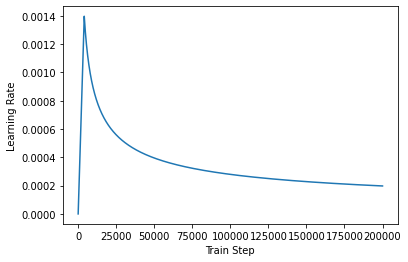

In [36]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
# tf.keras.backend.clear_session()

# model = transformer(
#     vocab_size=VOCAB_SIZE,
#     num_layers=NUM_LAYERS,
#     units=UNITS,
#     d_model=D_MODEL,
#     num_heads=NUM_HEADS,
#     dropout=DROPOUT)

### Compile

In [37]:
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0014, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# initialize and compile model within strategy scope
with strategy.scope():
  model = transformer(
      vocab_size=VOCAB_SIZE,
      num_layers=NUM_LAYERS,
      units=UNITS,
      d_model=D_MODEL,
      num_heads=NUM_HEADS,
      dropout=DROPOUT)

  model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
  # model.compile(optimizer=optimizer, metrics=[accuracy])

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 input2 (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['input1[0][0]']                 
                                                                                        

In [38]:
model.fit(dataset, epochs=EPOCHS)

1191/1191 [==============================] - 136s 92ms/step - loss: 1.8631 - accuracy: 0.0906


In [45]:
# Save the transformer model as a SavedModel.
save_directory = "/content/drive/MyDrive/code/saved_tfbase_models" 
model.save(save_directory)

In [46]:
model.save_weights(save_directory)

Load the model

In [47]:
new_model = tf.keras.models.load_model(save_directory,  compile=False)
new_model.load_weights(save_directory)
# Check its architecture
new_model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 input2 (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['input1[0][0]']                 
                                                                                        

### Evaluate and Predict


In [48]:
def evaluate(sentence, context):
  sentence = preprocess_sentence(str(sentence))
  context = preprocess_sentence(str(context))

  sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(str(sentence)) + END_TOKEN, axis=0)
  context = tokenizer.encode(str(context))

  # input = tf.concat([sentence, context], -1)  
  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = new_model(inputs=[sentence, context, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence, context):
  prediction = evaluate(sentence,context)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Context: {}'.format(context))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [49]:
output = predict('I was very happy to get my new job', 'excited')

Input: I was very happy to get my new job
Context: excited
Output: i am so happy for you . i am sure you will be able to get a lot of time .


In [50]:
output = predict('My first baby is on the way. I am going to make sure they have a great life.', 'grateful')

Input: My first baby is on the way. I am going to make sure they have a great life.
Context: grateful
Output: i am so sorry to hear that . i am sure you will be able to get a lot of time .


In [51]:
output = predict('I was hoping that I would do better on a math test.', 'grateful')

Input: I was hoping that I would do better on a math test.
Context: grateful
Output: i am so sorry to hear that . i am sure you will be able to get a lot of time .


In [52]:
output = predict('I am very happy to have been first over 300 students during this years at my enginering school', 'excited')

Input: I am very happy to have been first over 300 students during this years at my enginering school
Context: excited
Output: i am so happy for you . i am sure you will be able to get a lot of time .


In [53]:
print(evaluate("Hello how are you?", "grateful"))


tf.Tensor(
[8172    1   14   19  254    5  221  118    2    1   14  112   21   54
   35  180    5   42    6  139   15  700    3], shape=(23,), dtype=int32)


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 22.0 MB/s eta 0:00:00


In [ ]:
## predict context
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
save_directory = "/content/drive/MyDrive/code/saved_db_models" 
tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained(save_directory)
model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained(save_directory)
context = 0
def predict_context(sentence):
  predict_input = tokenizer_fine_tuned.encode(
    sentence,
    truncation = True,
    padding = True,
    return_tensors = 'tf'    
  )
  output = model_fine_tuned(predict_input)[0]

  prediction_value = tf.argmax(output, axis = 1).numpy()[0]
  context_dict = {0:'disappointed', 1: 'annoyed', 2: 'excited', 3:'afraid', 4:'disgusted', 5:'grateful', 6:'impressed',7:'prepared',}
  for k,v in context_dict.items():
    if prediction_value.item() == k:
      context = v
  return context 


Some layers from the model checkpoint at /content/drive/MyDrive/code/saved_db_models were not used when initializing TFDistilBertForSequenceClassification: ['dropout_39']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/code/saved_db_models and are newly initialized: ['dropout_109']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def evaluate2(sentence, context):
  sentence = preprocess_sentence(str(sentence))
  context = preprocess_sentence(str(context))

  sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(str(sentence)) + END_TOKEN, axis=0)
  context = tokenizer.encode(str(context))

  # input = tf.concat([sentence, context], -1)  
  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, context, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  context = predict_context(sentence)
  prediction = evaluate2(sentence,context)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])
  print('Predicted_context: {}'.format(context))
  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
output = predict('I was very happy to get my new job')

Predicted_context: disgusted
Input: I was very happy to get my new job
Output: i am so glad you had a great time . i am sure you will get a good time .


In [ ]:
# translate("Hello how are you", "grateful")

In [ ]:
# feed the model with its previous output - might need to predic context
# need to make changes to the context 
sentence = 'I am not crazy, my mother had me tested.'

## need an emotional classifier as well as a response prefix...
context = 'grateful'
for _ in range(5):
  sentence = predict(sentence, context)
  print('')

Input: I am not crazy, my mother had me tested.
Context: grateful
Output: i am so proud of my friend for a vacation this year

Input: i am so proud of my friend for a vacation this year
Context: grateful
Output: i am so happy for you . i am so excited .

Input: i am so happy for you . i am so excited .
Context: grateful
Output: i am so happy for you . i am so excited !

Input: i am so happy for you . i am so excited !
Context: grateful
Output: i am so happy for you . i am so excited !

Input: i am so happy for you . i am so excited !
Context: grateful
Output: i am so happy for you . i am so excited !



# Amanda's Loading Test

## Trying saving stuff

In [ ]:
model.save_weights('/content/drive/MyDrive/code/AmandaTestSave')

In [ ]:
tf.keras.models.save_model(model, '/content/drive/MyDrive/code/AmandaTestSave')

AttributeError: ignored

## Trying loading stuff

In [ ]:
loaded_model = tf.saved_model.load('/content/drive/MyDrive/sample_tf_base_model')

In [ ]:
loaded_model = model.load_weights('/content/drive/MyDrive/code/AmandaTestSave')

## Modified evaluate and predict function
uses loaded_model instead of model
evaluate becomes test_evaluate
predict becomes test_predict

In [ ]:
def test_evaluate(sentence, context):
  sentence = preprocess_sentence(str(sentence))
  context = preprocess_sentence(str(context))

  sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(str(sentence)) + END_TOKEN, axis=0)
  context = tokenizer.encode(str(context))

  # input = tf.concat([sentence, context], -1)  
  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = loaded_model(inputs=[sentence, context, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def test_predict(sentence, context):
  prediction = test_evaluate(sentence,context)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Context: {}'.format(context))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
# feed the model with its previous output - might need to predic context
# need to make changes to the context 
sentence = 'I am not crazy, my mother had me tested.'

## need an emotional classifier as well as a response prefix...
context = 'grateful'
for _ in range(5):
  sentence = test_predict(sentence, context)
  print('')

TypeError: ignored